# CLINT WP5: DEVELOPMENT: Application of cluster masks to diferent grids
## Climate simulations have different resolution compared to ECMWF, this requires a further step in the application of the mask to the grid
### 2023/10/13 - 2023/10/16


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import importlib
import seaborn as sns
#from mpl_toolkits import Basemap
import CLINT001_functions as clint
importlib.reload(clint)

<module 'CLINT001_functions' from '/users_home/csp/as18623/CLINT001_functions.py'>

In [2]:
## DIRECTORIES
machine = 'juno'
kind = 'hist' #ERA5 or hist


if machine == 'laptop':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    metadatadir = '~/Library/Mobile\ Documents/com~apple~CloudDocs/CLINT/metadata/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/squintu/Documents/CMCC-GoogleDrive/plots_for_reports/'
    
if machine == 'workstation':
    modeldir = '~/Documents/CMCC-GoogleDrive/ERA5/'
    metadatadir = '~/Library/Mobile\ Documents/com~apple~CloudDocs/CLINT/metadata/'
    maskdir = '~/Documents/CMCC-GoogleDrive/Mask_Clusters/Test3_Clusters/'
    plotdir = '/Users/antonellosquintu/Documents/CMCC-GoogleDrive/plots_for_reports/'

if machine == 'juno':
    modeldir = f'/work/csp/as18623/CLINT_{kind}/'
    obsdir = '/data/csp/as18623/CLINT_obs/'
    workmetadir = '/work/csp/as18623/CLINT_metadata/'
    metadatadir = '/data/csp/as18623/CLINT_metadata/'
    maskdir = '/data/csp/as18623/CLINT_metadata/Masks/Test3_Clusters/'
    plotdir = '/work/csp/as18623/CLINT_WP5/maps_and_plots/'

In [3]:
modelspecs = pd.DataFrame({'kind':['ERA5','hist'],
                           'modelnames':['era5','CMCC-CM2-SR5'],#name of models
                           'members_list':[np.nan,np.array(range(3,12))]})#list of member numbers)

modelspecs = pd.DataFrame({'kind':['ERA5','hist'],
                           'modelnames':['era5','CMCC-CM2-SR5'],#name of models
                           'members_list':[np.nan,[3]]})#list of member numbers)


In [4]:
## Open land-sea mask and round to integer
## The mask has values between 0 and 1 according to the proportion of the grid-point
##  which is covered by land
## Any gridpoint with more than 0.5 is rounded to 1 and considered land

lsm = xr.open_dataset(f'{obsdir}/era5_lsm.nc').round()

In [5]:
variables = ['tmax']

In [6]:
## indicate the date of the events and the variables to be included

dates_ts = (pd.to_datetime("2022-07-22"), 
            pd.to_datetime("2019-06-27"), 
            pd.to_datetime("2003-08-11"), 
            pd.to_datetime("1983-07-21"))

## don't run too many dates at once otherwise the notebook won't open next time

dates_ts = [pd.to_datetime("2019-06-27")]

variables = ['tmax','mslp','sm']

In [7]:
drivers = pd.read_csv(f'{workmetadir}drivers.csv')
modelspecs = modelspecs[modelspecs.kind == kind]

### Portions from clint.loop_map_grids

In [8]:
date_ts = dates_ts[0]
y = date_ts.year
#print(y)
kind = modelspecs.iloc[0]['kind']
datasetnames = sum([[f'{modelrow["modelnames"]}-{kind}-r{mmb}' for mmb in modelrow["members_list"]] for i, modelrow in modelspecs.iterrows()],[])

In [9]:
var = 'tmax'
drivers_sub = drivers.loc[drivers['var'] == var]
datasetname = datasetnames[0]
anom_xr = xr.open_dataset(f'{modeldir}/{datasetname}_{var}_dailyanom_{y}_cropped.nc')

In [10]:
drivers_row = drivers_sub.iloc[0]
mask_df = pd.read_csv(f"{maskdir}{drivers_row['clmask_test3']}",index_col=[0])
cl_nr = drivers_row['cl_nr']
submask = mask_df[mask_df.cluster == cl_nr]

### Portions from clint.mask_xr_w_df

In [11]:
xrdf = anom_xr

In [12]:
## Generate coordinates of all gridpoints around the 2x2
exp_list = [clint.expand_res_grid(row) for index,row in submask.iterrows()] 
## Concatenate dataframes with all the new gridpoints
exp_df = pd.concat(exp_list,ignore_index=True).reset_index(drop=True)
exp_df['cluster'] = np.nanmean(submask['cluster']) #add the missing column so that it can be merged to submask
## Append the new gridpoints to the original 2x2 mask
submask_exp = pd.concat([submask,exp_df],ignore_index=True).drop_duplicates().reset_index(drop=True)

mask = submask_exp.assign(flag=1).set_index(["nodes_lon", "nodes_lat"]).flag.to_xarray().fillna(0).rename({"nodes_lon": "longitude", "nodes_lat": "latitude"})

if (kind == 'hist'):
    lonfield = 'lon'
    latfield = 'lat'
else:
    lonfield = 'longitude'
    latfield = 'latitude'


In [13]:
coarse = mask.interp(longitude=xrdf[lonfield], 
                     latitude=xrdf[latfield], 
                     method="nearest")
coarse = coarse.fillna(0)

In [14]:
# coarse1 = coarse.reindex(longitude=xrdf[lonfield], 
#                     latitude=xrdf[latfield],
#                     method="nearest", tolerance=1e-9, fill_value=0)

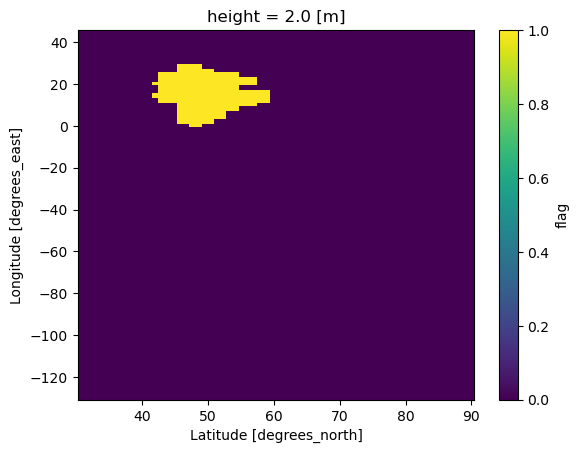

In [15]:
coarse.plot()

In [16]:
sub_xrdf = xrdf.where(coarse)

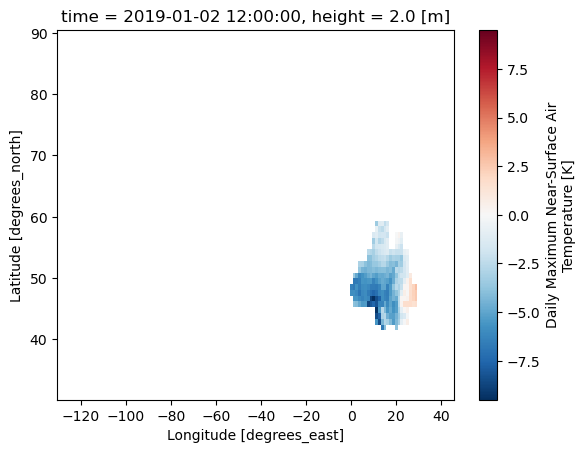

In [17]:
sub_xrdf.isel(time=1)['tasmax'].plot()

In [34]:
xrdf[lonfield]

<xarray.DataArray 'lon' (lon: 141)>
array([-130.  , -128.75, -127.5 , -126.25, -125.  , -123.75, -122.5 , -121.25,
       -120.  , -118.75, -117.5 , -116.25, -115.  , -113.75, -112.5 , -111.25,
       -110.  , -108.75, -107.5 , -106.25, -105.  , -103.75, -102.5 , -101.25,
       -100.  ,  -98.75,  -97.5 ,  -96.25,  -95.  ,  -93.75,  -92.5 ,  -91.25,
        -90.  ,  -88.75,  -87.5 ,  -86.25,  -85.  ,  -83.75,  -82.5 ,  -81.25,
        -80.  ,  -78.75,  -77.5 ,  -76.25,  -75.  ,  -73.75,  -72.5 ,  -71.25,
        -70.  ,  -68.75,  -67.5 ,  -66.25,  -65.  ,  -63.75,  -62.5 ,  -61.25,
        -60.  ,  -58.75,  -57.5 ,  -56.25,  -55.  ,  -53.75,  -52.5 ,  -51.25,
        -50.  ,  -48.75,  -47.5 ,  -46.25,  -45.  ,  -43.75,  -42.5 ,  -41.25,
        -40.  ,  -38.75,  -37.5 ,  -36.25,  -35.  ,  -33.75,  -32.5 ,  -31.25,
        -30.  ,  -28.75,  -27.5 ,  -26.25,  -25.  ,  -23.75,  -22.5 ,  -21.25,
        -20.  ,  -18.75,  -17.5 ,  -16.25,  -15.  ,  -13.75,  -12.5 ,  -11.25,
        -10.  ,   -8.75,   -7.5 ,   -6.25,   -5.  ,   -3.75,   -2.5 ,   -1.25,
          0.  ,    1.25,    2.5 ,    3.75,    5.  ,    6.25,    7.5 ,    8.75,
         10.  ,   11.25,   12.5 ,   13.75,   15.  ,   16.25,   17.5 ,   18.75,
         20.  ,   21.25,   22.5 ,   23.75,   25.  ,   26.25,   27.5 ,   28.75,
         30.  ,   31.25,   32.5 ,   33.75,   35.  ,   36.25,   37.5 ,   38.75,
         40.  ,   41.25,   42.5 ,   43.75,   45.  ])
Coordinates:
  * lon      (lon) float64 -130.0 -128.8 -127.5 -126.2 ... 41.25 42.5 43.75 45.0
    height   float64 ...
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    axis:           X
    bounds:         lon_bnds